In [2]:
%matplotlib inline
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams.update({
    "figure.dpi": 600,
    "figure.figsize": (6, 2.5),
    "font.size": 8,
    "mathtext.fontset": "stix"
})

In [3]:
# Load vmem simulation data
base_dir_vmem = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/vmem_data_neo' 

vmem_amp_file_paths = [
    os.path.join(base_dir_vmem, f'vmem_amp_data_neo_Ez_{i}.npy')
    for i in range(16)
]

vmem_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in vmem_amp_file_paths
]
vmem_amp_data = {}
for data in vmem_amp_data_list:
    vmem_amp_data.update(data)

In [4]:
# Load cdm simulation data
base_dir_cdm = '/Users/susannedahle/CellTypeDependenceElStim/simulation_data/cdm_and_imem_data_neo' 

cdm_amp_file_paths = [
    os.path.join(base_dir_cdm, f'cdm_and_imem_data_neo_{i}.npy')
    for i in range(8)
]

cdm_amp_data_list = [
    np.load(path, allow_pickle=True).item()
    for path in cdm_amp_file_paths
]
cdm_amp_data = {}
for data in cdm_amp_data_list:
    cdm_amp_data.update(data)

In [5]:
selected_cells = ['L4_BP_bIR215_5', "L5_MC_bAC217_1", "L5_TTPC2_cADpyr232_3", "L5_NGC_bNAC219_5", 'L4_SS_cADpyr230_1']

cell_names = {
    'L4_BP_bIR215_5': 'L4 Bipolar cell (BP)',
    "L5_MC_bAC217_1": "L5 Martinotti cell (MC)",
    "L5_TTPC2_cADpyr232_3": "L5 Pyramidal cell (TTPC)",
    "L5_NGC_bNAC219_5": "L5 Neurogliaform cell (NGC)",
    'L4_SS_cADpyr230_1': 'L4 Spiny Stellate cell (SS)'
}

short_cell_names = {
    'L4_BP_bIR215_5': 'L4 BP',
    "L5_MC_bAC217_1": "L5 MC",
    "L5_TTPC2_cADpyr232_3": "L5 TTPC",
    "L5_NGC_bNAC219_5": "L5 NGC",
    'L4_SS_cADpyr230_1': 'L4 SS'
}

cell_vmem_colors = {
    'L4_BP_bIR215_5': "tab:grey",
    "L5_MC_bAC217_1": "tab:cyan",
    "L5_TTPC2_cADpyr232_3": "tab:olive",
    "L5_NGC_bNAC219_5": 'tab:brown',
    'L4_SS_cADpyr230_1': 'tab:pink'
}

cell_cdm_colors = {
    'L4_BP_bIR215_5': "tab:orange",
    "L5_MC_bAC217_1": "tab:blue",
    "L5_TTPC2_cADpyr232_3": "tab:green",
    "L5_NGC_bNAC219_5": 'tab:red',
    'L4_SS_cADpyr230_1': 'tab:purple'
}

In [6]:
def plot_vmem_cdm_comparrison(vmem_amp_data, cdm_amp_data, selected_cells):
    """
    Reproduces Figure 20 with three subplots:
    (A) Soma Vm amplitudes
    (B) CDM amplitudes
    (C) Normalized combined amplitudes
    """

    # --- Create figure and subplots ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 2.5))
    fig.subplots_adjust(bottom=0.25, left=0.07, right=0.97, top=0.88, wspace=0.4)
    plt.rcParams['mathtext.fontset'] = 'stix'

    # ---- Subplot A: Soma Vmem Amplitudes ----
    i = 0
    for cell_name, data in vmem_amp_data.items():
        if cell_name in selected_cells:
            freqs = np.array(data["freq"])
            amps = np.array(data["soma_amp"])
            ax1.loglog(freqs, amps, lw=1.5, label=short_cell_names[cell_name],
                       color=cell_vmem_colors[cell_name], linestyle='-')
            i += 1

    ax1.set_xlabel("Frequency [Hz]")
    ax1.set_ylabel("Soma $V_\mathrm{m}$ Amplitude [mV]")
    ax1.set_title("Extracellular stimulation")
    ax1.grid(True, linestyle='--', linewidth=0.5)
    ax1.set_ylim(top=0.5)
    ax1.set_xlim(left=1, right=2000)

    # ---- Subplot B: CDM Amplitudes ----
    i = 0
    for cell_name, data in cdm_amp_data.items():
        if cell_name in selected_cells:
            freqs = np.array(data["frequency"])
            amps = np.array(data["cdm_per_input_current"])
            cdm_amps = np.array(data["cdm"])
            if i == 0:
                print('cdm:', cdm_amps)
            ax2.loglog(freqs, amps, lw=1.5, label=short_cell_names[cell_name], color=cell_cdm_colors[cell_name], linestyle = '--')
            i += 1

    ax2.set_xlabel("Frequency [Hz]")
    ax2.set_ylabel("$p_z$ / $I_{in}$ [µm]")
    ax2.set_title("White noise Input")
    ax2.grid(True, linestyle='--', linewidth=0.5)
    #ax2.set_ylim(top=2.5)
    ax2.set_xlim(left=1, right=2000)

    # ax2.set_xlabel("Frequency [Hz]")
    # ax2.set_ylabel("Dipole Moment Amplitude [nA·µm]")
    # ax2.set_title("White noise Input")
    # ax2.grid(True, linestyle='--', linewidth=0.5)
    # ax2.set_ylim(top=2.5)
    # ax2.set_xlim(left=1, right=2000)


    i = 0
    for cell_name, data in vmem_amp_data.items():
        if cell_name in selected_cells:
            freqs = np.array(data["freq"])
            amps = np.array(data["soma_amp"])
            if i == 0:
                print('soma amp:', amps)
            ax3.loglog(freqs, amps, lw=1.5, label=short_cell_names[cell_name],
                       color=cell_vmem_colors[cell_name], linestyle='-')
            i += 1
    i = 0 # CDM PER INPUT CURRENT SCALING
    for cell_name, data in cdm_amp_data.items():
        if cell_name in selected_cells:
            freqs = np.array(data["frequency"])
            cdm_amps_scaled = np.array(data["cdm_per_input_current"]/1000)
            amps = np.array(data["cdm_per_input_current"])
            if i == 0:
                print('cdm per input:', amps)
            ax3.loglog(freqs, cdm_amps_scaled, lw=1.5, label=short_cell_names[cell_name], color=cell_cdm_colors[cell_name], linestyle = '--')
            i += 1
    # i = 0 #CDM SCALING
    # for cell_name, data in cdm_amp_data.items():
    #     if cell_name in selected_cells:
    #         freqs = np.array(data["frequency"])
    #         cdm_amps_scaled = np.array(data["cdm"]*0.210)
    #         amps = np.array(data["cdm"])
    #         if i == 0:
    #             print('scaled cdm:', cdm_amps_scaled)
    #             print('cdm:', amps)
    #         ax3.loglog(freqs, cdm_amps_scaled, lw=1.5, label=short_cell_names[cell_name], color=cell_cdm_colors[cell_name], linestyle = '--')
    #         i += 1

    ax3.set_xlabel("Frequency [Hz]")
    ax3.set_ylabel("[mV]")
    ax3.set_title("Scaled")
    ax3.grid(True, linestyle='--', linewidth=0.5)
    #ax2.set_ylim(top=2.5)
    ax3.set_xlim(left=1, right=2000)


    # # ---- Subplot C: Normalized Combined ----
    # # Max for soma
    # soma_global_max = 0
    # for cell_name, data in vmem_amp_data.items():
    #     if cell_name in selected_cells:
    #         freqs = np.array(data["freq"])
    #         amps = np.array(data["soma_amp"])
    #         mask = (freqs >= 1) & (freqs <= 2100)
    #         max_val = np.max(amps[mask])
    #         if max_val > soma_global_max:
    #             soma_global_max = max_val

    # # Plot normalized Soma Vm
    # i = 0
    # for cell_name, data in vmem_amp_data.items():
    #     if cell_name in selected_cells:
    #         freqs = np.array(data["freq"])
    #         amps = np.array(data["soma_amp"])
    #         mask = (freqs >= 1) & (freqs <= 2000)
    #         amps_norm = amps[mask] / soma_global_max
    #         ax3.loglog(freqs[mask], amps_norm, lw=1.5, linestyle='-',
    #                    label=f"{short_cell_names[cell_name]} ($V_m$)", color=cell_vmem_colors[cell_name])
    #         i += 1

    # ax3.set_xlabel("Frequency [Hz]")
    # ax3.set_ylabel("Normalized Amplitude")
    # ax3.set_title("Normalized Responses")
    # ax3.grid(True, linestyle='--', linewidth=0.5)
    # ax3.set_xlim(left=1, right=2000)
    # ax3.set_ylim(bottom=1e-2, top=1.5)
    
    # # Max for CDM
    # cdm_global_max = 0
    # for cell_name, data in cdm_amp_data.items():
    #     if cell_name in selected_cells:
    #         freqs = np.array(data["frequency"])
    #         amps = np.array(data["cdm_per_input_current"])
    #         mask = (freqs >= 1) & (freqs <= 2000)
    #         max_val = np.max(amps[mask])
    #         if max_val > cdm_global_max:
    #             cdm_global_max = max_val

    # # Plot normalized CDM
    # i = 0
    # for cell_name, data in cdm_amp_data.items():
    #     if cell_name in selected_cells:
    #         freqs = np.array(data["frequency"])
    #         amps = np.array(data["cdm_per_input_current"])
    #         mask = (freqs > 0) & (freqs <= 2000)
    #         amps_norm = amps[mask] / cdm_global_max
    #         ax3.loglog(freqs[mask], amps_norm, lw=1.5, linestyle='--',
    #                    label=f"{short_cell_names[cell_name]} ($p_z$)",
    #                    color=cell_cdm_colors[cell_name])
    #         i += 1

    # ---- Legend underneath all subplots ----
    legend_elements = []
    for cell_name in selected_cells:
        cdm_line = Line2D([0], [0], color=cell_cdm_colors[cell_name], lw=1.5, linestyle='--',
                          label=f'{short_cell_names[cell_name]} ( $p_z$)')
        vmem_line = Line2D([0], [0], color=cell_vmem_colors[cell_name], lw=1.5, linestyle='-',
                           label=f'{short_cell_names[cell_name]} ($V_m$)')
        legend_elements.extend([cdm_line, vmem_line])

    fig.legend(handles=legend_elements,
               loc='lower center',
               ncol=len(selected_cells),
               bbox_to_anchor=(0.5, -0.07),
               handletextpad=1.0,
               columnspacing=1.0,
               frameon=False)
    
    ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=12, fontweight='bold')
    ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, fontsize=12, fontweight='bold')
    ax3.text(-0.15, 1.05, 'C', transform=ax3.transAxes, fontsize=12, fontweight='bold')

    plt.show()


<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/var/folders/bg/0phzw_wj05x5crg_p858d9b80000gn/T/ipykernel_24711/2301553461.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_ylabel("Soma $V_\mathrm{m}$ Amplitude [mV]")


cdm: [1.18544197 1.45148789 1.57615709 1.63409041 1.64937957 1.65018201
 1.6373772  1.61952971 1.59507614 1.56901585 1.25411946 0.99782311
 0.8200518  0.69590406 0.6057199  0.53813169 0.48488283 0.44238732
 0.40746523 0.23614843 0.17351921 0.14189989 0.12284594 0.10992672
 0.10036144 0.09284426 0.08672249 0.08156565 0.07712004 0.07328129
 0.06987769 0.06684121 0.06410968 0.06164367 0.05941412 0.05735319
 0.05546917 0.05373034 0.05210694]
soma amp: [0.23965353 0.292216   0.31681881 0.32697597 0.33028672 0.32998984
 0.32756198 0.32376032 0.31902227 0.31362878 0.25065837 0.19937701
 0.16384523 0.13905048 0.12107618 0.10752054 0.09693843 0.08843723
 0.0814454  0.04727631 0.03486105 0.02857781 0.0247668  0.0221565
 0.02021466 0.01868704 0.01743837 0.01638984 0.01549187 0.01471125
 0.01402457 0.01341468 0.01286863 0.01237638 0.01193    0.01152313
 0.01115059 0.01080812 0.01049218]
cdm per input: [237.08929797 290.29868607 315.23262077 326.8193282  329.87717171
 330.03766192 327.47668929 323.

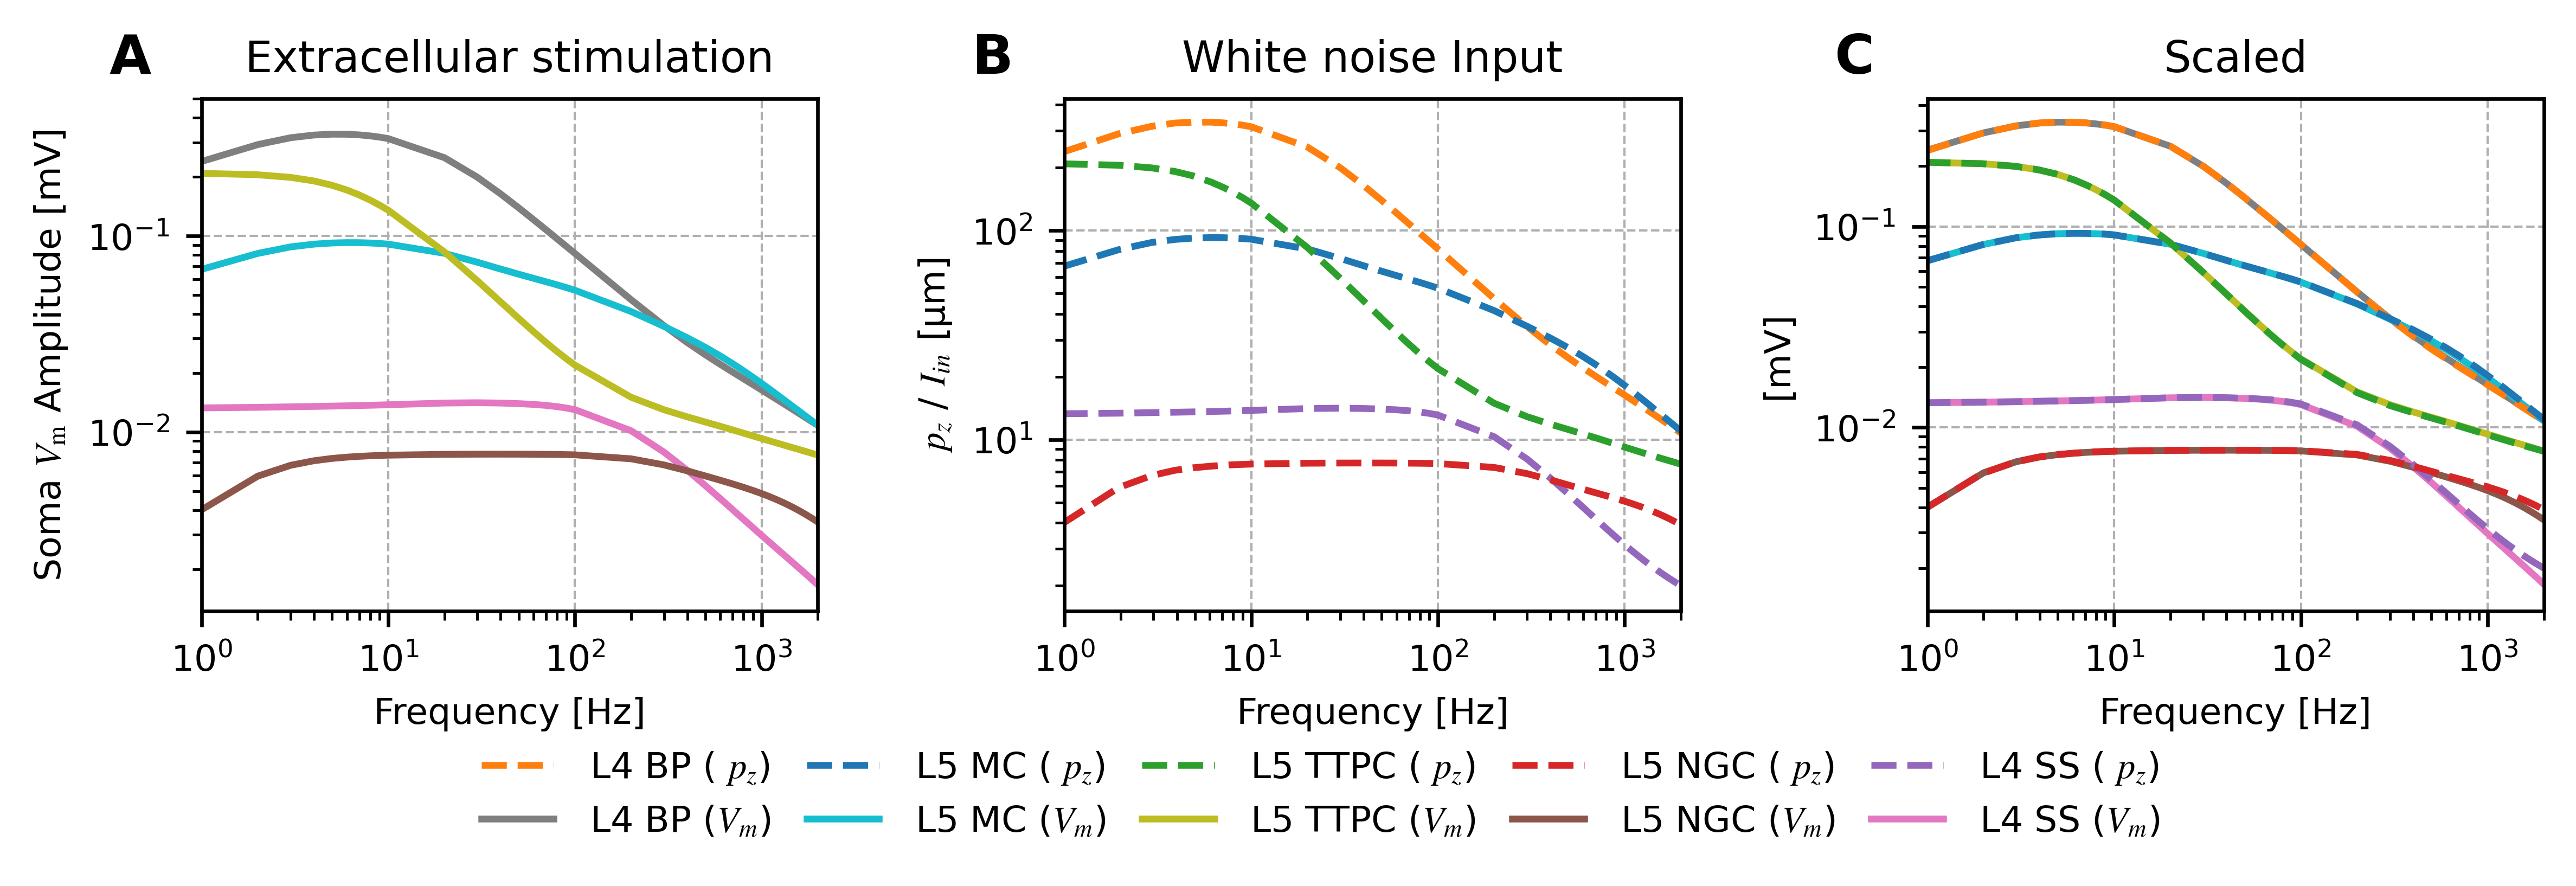

In [7]:
plot_vmem_cdm_comparrison(vmem_amp_data, cdm_amp_data, selected_cells)

In [18]:
1/(0.21*10**-3)

4761.9047619047615